# Important Memo #

Things to change when going on the cloud : 
- "Initialization of the Spark Context" -> conf, setMaster
- Creating the Dataframe -> ressource_path -> "Ressources/fruits-360_dataset/fruits-360/Training"

# Imports #

In [1]:
# Standard Libraries
import os
import numpy as np
from scipy.cluster.vq import vq
import re
from time import time
import matplotlib.pyplot as plt

# Pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StringType, FloatType, ArrayType, StructField

# Image Preprocessing 
import cv2 as cv

# Machine Learning for Dimensions Reduction
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

# S3 Manager
import boto3
from boto3.session import Session

# Set-ups #
## Initialization of the Spark context ##

In [2]:
t_omega = time()
conf = SparkConf().setAppName("fruit_image_preprocessing")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName("fruit_image_preprocessing").getOrCreate()

21/10/12 15:57:34 WARN Utils: Your hostname, muninn-System-Product-Name resolves to a loopback address: 127.0.1.1; using 192.168.1.73 instead (on interface enp0s31f6)
21/10/12 15:57:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/12 15:57:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Variables ##

In [3]:
global ressource_path, image_path, preprocessed_path, dot_split

# Get the paths
ressource_path = 'Ressources/Local_Test/'
image_path = 'Ressources/Local_Test/Images/'
preprocessed_path = 'Ressources/Local_Test/Preprocessed Images/'

# Make a directory for the preprocessed images
os.makedirs(preprocessed_path, exist_ok=True)

# Make a list of all fruit types
fruit_type_list = os.listdir(image_path)

# Regex for later
dot_split = re.compile("\.")

## Functions to be used ##

We will be using quite a number of functions to pipeline the image preprocessing, so we will define them all here.

### DataFrame Related Functions ###

In [4]:
# Fill the dataframe with fruits
def fill_df(fruit_type, image):
    image_name = dot_split.split(image)[0]
    ID = f'{image_name}_{fruit_type}'
    fruit = {
        'ID': ID,                    
        'Image_name': image_name,
        'Type_of_fruit': fruit_type,
    }
    return fruit

### Preprocessing ###

#### Individual Image Preprocessing ####

##### Find the Path of the Image From the Dataframe and Load the Image #####

In [5]:
# Get the path of the image and read it
def find_path_image(image_name, fruit_type):
    image_type_path = image_path + fruit_type
    path = image_type_path + '/' + image_name + '.jpg'
    image = cv.imread(path)
    return image

True

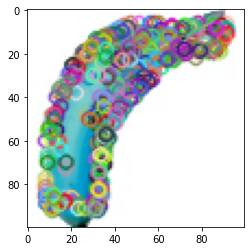

In [40]:
path = 'Ressources/Local_Test/Images/Banana Lady Finger/0_100.jpg'
image = cv.imread(path)
image_colored = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cv.imwrite('test_image.png', image)
test_image = grey_scale(image)
test_image = automatic_brightness_and_contrast(test_image)
test_image = filtering_image(test_image)
kp, des = create_descriptors(test_image)

test_image_keypoints = np.empty((test_image.shape[0], 
                                test_image.shape[1], 3), dtype=np.uint8)

cv.drawKeypoints(image, kp, test_image_keypoints, 
                 flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

plt.imshow(test_image_keypoints)
cv.imwrite('test_image_keypoints.png', test_image_keypoints)

##### Grey Scale #####

In [6]:
# Turn the image to greyscale
def grey_scale(image):
    grey_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return grey_image

##### Exposition and Contrast #####
Function form stackoverflow user nathancy, from https://stackoverflow.com/questions/57030125/automatically-adjusting-brightness-of-image-with-opencv

In [7]:
def automatic_brightness_and_contrast(image, clip_hist_percent=25):
    # Calculate grayscale histogram
    hist = cv.calcHist([image],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result)

##### Noise #####

In [8]:
# Filtering the noise of the image by blurring it
def filtering_image(image):
    # This argument will enable us to have an output image the same size of the input one
    ddepth = -1
    
    # Creating a kernel for a normalized box filter
    kernel = np.array(([[1,-1,1],
                        [-1,1,-1],
                        [1,-1,1]]), dtype=np.float32)
    
    # Apply the filter
    output_image = cv.filter2D(image, ddepth, kernel)
    
    return output_image

##### Create Descriptors #####

In [9]:
# Get the descriptors of the image thanks to the ORB method
def create_descriptors(image):
    orb = cv.ORB_create(nfeatures=1200, edgeThreshold=6)
    kp, des = orb.detectAndCompute(image, None)
    return kp, des

##### Save Descriptors in Dictionnary #####

In [10]:
# Make a dictionnary of the descriptor for one given image
def create_des_dict(ID, descriptors):
    des_dict= {
        'ID': ID,
        'descriptors': descriptors.tolist()
    }
    return des_dict

#### Compile All These Steps ####

In [11]:
def preprocessing_image(ID, preprocessed_path=preprocessed_path):
    # Getting the image's name and fruit type
    split_ID = re.compile("_")
    fruit_type = split_ID.split(ID)[-1]
    split_fruit = re.compile(f"_{fruit_type}")
    image_name = split_fruit.split(ID)[0]
    
    # Preprocessing in itself
    image = find_path_image(image_name, fruit_type)
    try:
        image = grey_scale(image)
    except:
        print(image_name)
        print(fruit_type)
        print(image.shape)
        return
    image = automatic_brightness_and_contrast(image)
    image = filtering_image(image)

    # Saving the image
    cv.imwrite(f"{preprocessed_path}/{fruit_type}/{image_name}.jpg", image)

    # Creating and saving descriptors
    keypoints, descriptors = create_descriptors(image)
    descriptors = descriptors.astype(float)
    np.savetxt(f"{preprocessed_path}/{fruit_type}/{image_name}_descriptors.csv", descriptors, delimiter=',')
    des_dict = create_des_dict(ID, descriptors)

    return des_dict

### Reducing Dimension ###

#### Stack Descriptors in a List ####

In [12]:
# Stacking verticaly the descriptors in a list to cluster them later
def stack_descriptors(des_df):
    print('Stacking Descriptors...')
    t0 = time()
    
    # Function to stack a descriptor vertically in a numpy array
    def create_descriptors(x):
        descriptor = np.vstack(x)
        return descriptor
    
    descriptor_list_rdd = des_df.select("descriptors").rdd.flatMap(lambda x: x)
    descriptor_list_rdd = descriptor_list_rdd.map(lambda x: create_descriptors(x))
    descriptor_list = np.vstack(descriptor_list_rdd.collect()).astype(float)
    
    t1 = time()
    print("Time taken to stack descriptors : {:.2f} s or {:.2f} min.".format(t1-t0, (t1-t0)/60))
    
    return descriptor_list

#### Creations of Bags of Visual Words ####

In [13]:
# Clustering the descriptors making Bags of Visual Words
def create_BoVW(descriptors, df_size):
    print('Clustering descriptors...')
    k = int(round(np.sqrt(df_size[0]), 0))
    print('Estimated number of clusters : {}'.format(k))
    t0 = time()

    kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
    kmeans.fit(descriptors, k, 1)

    voc = kmeans.cluster_centers_

    t1 = time()
    elapsed = t1 -t0
    print('Clustering time : {:.2f} s or {:.2f} min.'.format(elapsed, elapsed/60))
    
    return voc, k

#### Extract and Scale Image Features ####

In [14]:
def image_features(voc, k):
    print('Extracting and scaling image features...')
    t0 = time()
    
    # Extractions of the Images Features
    def features_extraction(image, k=k):
        image_features = np.zeros((k), 'float32')
        words, distance = vq(image, voc)
        for w in words:
            image_features[w] += 1
        return image_features
    
    descriptor_list_rdd = des_df.select("descriptors").rdd.flatMap(lambda x: x)
    img_features = descriptor_list_rdd.map(lambda x: features_extraction(x)).collect()

    # Scaling of the features
    scaler = StandardScaler()
    scaled_img_features = scaler.fit_transform(img_features)

    t1 = time()
    print("Time taken to extract and scale image features : {:.2f} s or {:.2f} min.".format(t1-t0, (t1-t0)/60))
    
    return scaled_img_features

#### Apply the PCA ####

In [15]:
# Testing a dimension reduction by PCA on the features
def test_pca(scaled_img_features):
    t0 = time()
    # Testing the PCA
    print('Testing Optimal Number of Components for the PCA')
    components_number = scaled_img_features.shape[1]
    components_number_list = [c for c in range(2, components_number)]
    components_number_list_rdd = sc.parallelize(components_number_list)
    
    schema = StructType([
        StructField("descriptors",ArrayType(ArrayType(FloatType(), True), True), True),
    ])
    
    def test_results(components):
        tstart = time()
        pca = PCA(n_components=components)
        X_PCA = pca.fit_transform(scaled_img_features)
        variance = pca.explained_variance_ratio_.sum()
        tc = time() - tstart
        return float(components), float(variance), float(tc)
    
    test_results_rdd = components_number_list_rdd.map(lambda x: test_results(x))
    test_results_df = spark.createDataFrame(test_results_rdd, ["Components", "Variance", "Time"])
    good_components_df = test_results_df.where(test_results_df.Variance > 0.95).select("Components")
    good_components_rdd = good_components_df.rdd.flatMap(lambda x: x)
    best_component = int(good_components_rdd.collect()[0])
    
    elapsed = time() - t0
    print("Done in {:.2f} s or {:.2f} min. Optimal Number of Components is {}.".format(elapsed, elapsed/60, best_component))
    
    return best_component, test_results_df

In [16]:
# Plotting the results of the test
def plotting_test(best_component, test_results_df):
    x = test_results_df.select('Components').rdd.flatMap(lambda x: x).collect()
    y = test_results_df.select('Variance').rdd.flatMap(lambda x: x).collect()
    labels = test_results_df.select('Time').rdd.flatMap(lambda x: x).collect()

    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    ax.plot(x, y)
    ax.text(1, 1, f'Best number of components = {best_component}')
    plt.axhline(y= 0.95, color = 'r', linestyle='--')
    plt.axvline(x=best_component, color = 'r', linestyle='--')
    ax.set(
        title='Analysis of Variance Explained over Number of Components',
        xlabel='Number of Components',
        ylabel='Variance Explained'
    )
    plt.show()

In [17]:
# Doing the PCA with the best number of components
def doing_pca(scaled_img_features, best_component):
    print('Operating Optimized PCA...')
    t0 = time()
    pca = PCA(n_components=best_component)
    X_PCA = pca.fit_transform(scaled_img_features)
    pca_var = pca.explained_variance_ratio_.sum()
    t1 = time()
    pca_time = t1-t0

    print('PCA with {} components explains {:.2f} variance and is done in {:.2f} s.'
          .format(best_component, pca_var, pca_time))
    
    return X_PCA

#### Save Reduced Features in Dataframe ####

In [18]:
# Saving the PCA Reduced Features
def save_features(X_PCA, des_df):
    print('Saving results...')
    t0 = time()
    ID_list = des_df.select("ID").rdd.flatMap(lambda x: x).collect()
    
    for i in range(len(ID_list)):
        ID = ID_list[i]
        split_ID = re.compile("_")
        fruit_type = split_ID.split(ID)[-1]
        split_fruit = re.compile(f"_{fruit_type}")
        fruit = split_fruit.split(ID)[0]
        features = X_PCA[i].tolist()
        np.savetxt(f"{preprocessed_path}/{fruit_type}/{fruit}_reduced_features.csv", features, delimiter=',')
        
    print("Results saved in {:.2f} s.".format(time() - t0))

#### Compile All These Steps ####

In [19]:
# Doing all the above steps
def reduce_dimensions():
    descriptors = stack_descriptors(des_df)
    voc, k = create_BoVW(descriptors, df_size)
    scaled_img_features = image_features(voc, k)
    best_component, test_results_df = test_pca(scaled_img_features)
    plotting_test(best_component, test_results_df)
    X_PCA = doing_pca(scaled_img_features, best_component)
    save_features(X_PCA, des_df)
    print("Features saved in the files 'reduced_features.csv' next to each preprocessed image.")

# Creating the Dataframe #

In [20]:
# For a fruit type, create a path, a list of all the fruit, make a 
# new preprocessed directory and add the missing fruits to the dataframe
t0 = time()

for fruit_type in fruit_type_list:
    image_type_path = image_path + fruit_type
    fruit_list_rdd = sc.parallelize(os.listdir(image_type_path))
    os.makedirs(preprocessed_path + fruit_type, exist_ok=True)
    operation = fruit_list_rdd.map(lambda x: fill_df(fruit_type, x))
    try:
        data_df = data_df.union(spark.createDataFrame(operation))
    except:
        data_df = spark.createDataFrame(operation)

data_df = data_df[['ID','Image_name', 'Type_of_fruit']]
data_df = data_df.dropDuplicates(['ID'])
print("Size of dataframe :({},{})".format(data_df.count(), len(data_df.columns)))
print(data_df.show(5))

t1 = time()
print("Time taken : {:.2f} s or {:.2f} min.".format(t1-t0, (t1-t0)/60))

Size of dataframe :(2316,3)


+---------------+----------+-------------+
|             ID|Image_name|Type_of_fruit|
+---------------+----------+-------------+
|  12_100_Plum 2|    12_100|       Plum 2|
|  157_100_Peach|   157_100|        Peach|
|  197_100_Peach|   197_100|        Peach|
|  284_100_Peach|   284_100|        Peach|
|r_109_100_Peach| r_109_100|        Peach|
+---------------+----------+-------------+
only showing top 5 rows

None
Time taken : 9.79 s or 0.16 min.


# Preprocessing Images #

In [21]:
# Preprocessing images and saving their descriptors in a file
t0 =time()

images_list_rdd = data_df.select("ID").rdd.flatMap(lambda x: x)
descriptor_list_rdd = images_list_rdd.map(lambda ID: preprocessing_image(ID))

schema = StructType([
    StructField("ID", StringType(), True),
    StructField("descriptors", ArrayType(ArrayType(FloatType(), True)), True),
])

des_df = spark.createDataFrame(descriptor_list_rdd, schema=schema)
df_size = (des_df.count(), len(des_df.columns))
print("Size of dataframe : {}".format(df_size))

t1 =time()
print("Time taken : {:.2f} s or {:.2f} min.".format(t1-t0, (t1-t0)/60))

Size of dataframe : (2316, 2)
Time taken : 13.46 s or 0.22 min.


# Applying PCA to Reduce the Dimensions of the Images Features #

Stacking Descriptors...


Time taken to stack descriptors : 15.86 s or 0.26 min.
Clustering descriptors...
Estimated number of clusters : 48
Clustering time : 10.70 s or 0.18 min.
Extracting and scaling image features...


Time taken to extract and scale image features : 29.71 s or 0.50 min.
Testing Optimal Number of Components for the PCA


Done in 4.12 s or 0.07 min. Optimal Number of Components is 36.


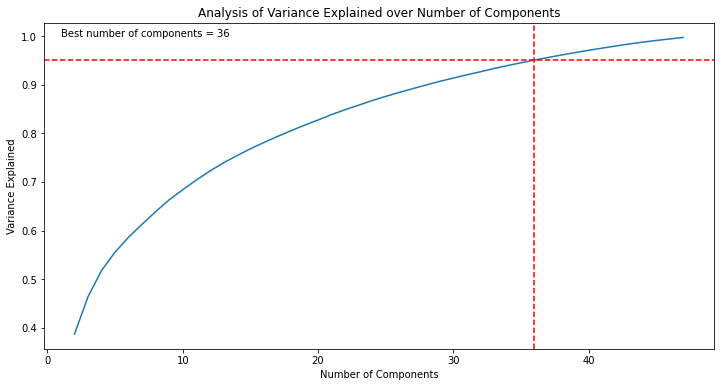

Operating Optimized PCA...
PCA with 36 components explains 0.95 variance and is done in 0.14 s.
Saving results...


Results saved in 13.96 s.
Features saved in the files 'reduced_features.csv' next to each preprocessed image.
Time taken : 82.33 s or 1.37 min.


In [22]:
# Extracting the image features from the descriptors and saving them in a file
t0 =time()

reduce_dimensions()

t1 =time()
print("Time taken : {:.2f} s or {:.2f} min.".format(t1-t0, (t1-t0)/60))

# Checking Time #

In [23]:
t_zeta = time()
total_time = t_zeta - t_omega
print("Total elapsed time for the notebook is : \n{:.2f} s, \nor {:.2f} min.".format(total_time, (total_time/60)))

Total elapsed time for the notebook is : 
111.37 s, 
or 1.86 min.


# Test on one image #